In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression

%matplotlib inline

    Построить рекомендации (регрессия, предсказываем оценку) на фичах:

    TF-IDF на тегах и жанрах
    Средние оценки (+ median, variance, etc.) пользователя и фильма

    Оценить RMSE на тестовой выборке


In [2]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
data = pd.merge(movies, tags, on='movieId', how='left')
data.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


In [4]:
data.describe()

,movieId,userId,timestamp
count,11853.000000,3683.000000,3.683000e+03
mean,40756.628195,431.149335,1.320032e+09
std,51463.872496,158.472553,1.721025e+08
min,1.000000,2.000000,1.137179e+09
25%,2900.000000,424.000000,1.137521e+09
50%,7022.000000,474.000000,1.269833e+09
75%,72998.000000,477.000000,1.498457e+09
max,193609.000000,610.000000,1.537099e+09


In [5]:
data.dropna(inplace=True)
data.describe()

,movieId,userId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,27252.013576,431.149335,1.320032e+09
std,43490.558803,158.472553,1.721025e+08
min,1.000000,2.000000,1.137179e+09
25%,1262.500000,424.000000,1.137521e+09
50%,4454.000000,474.000000,1.269833e+09
75%,39263.000000,477.000000,1.498457e+09
max,193565.000000,610.000000,1.537099e+09


In [6]:
data = pd.DataFrame(data.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))

In [7]:
data.head()

,tag
movieId,
1,pixar pixar fun
2,fantasy magic board game Robin Williams game
3,moldy old
5,pregnancy remake
7,remake


In [8]:
df = pd.merge(movies, data, on='movieId', how='left')

In [9]:
df.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake


In [10]:
df.dropna(inplace=True)

In [11]:
final = pd.merge(df, ratings, on='movieId', how='left')

In [12]:
final.head()

,movieId,title,genres,tag,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,17.0,4.5,1.305696e+09


In [13]:
final.head()

,movieId,title,genres,tag,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,17.0,4.5,1.305696e+09


In [14]:
median_rating = final.groupby('movieId').rating.median()
median_rating.head()

movieId
1    4.0
2    3.5
3    3.0
5    3.0
7    3.0
Name: rating, dtype: float64

In [15]:
median_rating.describe()

count    1554.000000
mean        3.715573
std         0.556692
min         0.500000
25%         3.500000
50%         4.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

In [16]:
median_rating.isnull()

movieId
1         False
2         False
3         False
5         False
7         False
          ...  
183611    False
184471    False
187593    False
187595    False
193565    False
Name: rating, Length: 1572, dtype: bool

In [17]:
median_rating [:] = np.nan_to_num(median_rating)
np.isnan(median_rating).sum()

0

In [18]:
final = pd.merge(final, median_rating, on='movieId', how='left')

In [19]:
final.head()

,movieId,title,genres,tag,userId,rating_x,timestamp,rating_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,1.0,4.0,9.649827e+08,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,5.0,4.0,8.474350e+08,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,7.0,4.5,1.106636e+09,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,15.0,2.5,1.510578e+09,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,17.0,4.5,1.305696e+09,4.0


In [20]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [21]:
vectorizer = TfidfVectorizer(stop_words = 'english')

In [22]:
final['genres'] = final['genres'].apply(change_string)

In [23]:
final[final.title == 'Solo: A Star Wars Story (2018)']

,movieId,title,genres,tag,userId,rating_x,timestamp,rating_y
48299,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,62.0,4.0,1.528935e+09,4.0
48300,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,380.0,4.0,1.536873e+09,4.0
48301,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,414.0,3.5,1.527978e+09,4.0
48302,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,514.0,3.0,1.537675e+09,4.0
48303,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,586.0,5.0,1.529900e+09,4.0


In [24]:
final['genres']

0        Adventure Animation Children Comedy Fantasy
1        Adventure Animation Children Comedy Fantasy
2        Adventure Animation Children Comedy Fantasy
3        Adventure Animation Children Comedy Fantasy
4        Adventure Animation Children Comedy Fantasy
                            ...                     
48300                Action Adventure Children SciFi
48301                Action Adventure Children SciFi
48302                Action Adventure Children SciFi
48303                Action Adventure Children SciFi
48304                  Action Animation Comedy SciFi
Name: genres, Length: 48305, dtype: object

In [25]:
tfidf_matrix = vectorizer.fit_transform(final['genres'])

In [26]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=final.index.tolist())
print(tfidf_df.shape)

(48305, 20)


In [27]:
print(final.shape)

(48305, 8)


In [28]:
tfidf_matrix2 = vectorizer.fit_transform(final['tag'])

In [29]:
tfidf_df2 = pd.DataFrame(tfidf_matrix2.toarray(), index=final.index.tolist())
print(tfidf_df2.shape)

(48305, 1673)


In [30]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df2)

In [31]:
latent_matrix.shape

(48305, 200)

In [32]:
tfidf2_svd = pd.DataFrame(latent_matrix, index=final.index.tolist())

In [33]:
datasets = [final, tfidf_df, tfidf2_svd]

In [34]:
result = pd.concat(datasets, axis = 1)
result.head()

,movieId,title,genres,tag,userId,rating_x,timestamp,rating_y,0,1,...,190,191,192,193,194,195,196,197,198,199
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,1.0,4.0,9.649827e+08,4.0,0.0,0.36091,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.01523,0.004673,-0.002139
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,5.0,4.0,8.474350e+08,4.0,0.0,0.36091,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.01523,0.004673,-0.002139
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,7.0,4.5,1.106636e+09,4.0,0.0,0.36091,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.01523,0.004673,-0.002139
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,15.0,2.5,1.510578e+09,4.0,0.0,0.36091,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.01523,0.004673,-0.002139
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,17.0,4.5,1.305696e+09,4.0,0.0,0.36091,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.01523,0.004673,-0.002139


In [35]:
result.dropna(axis = 1)

,movieId,title,genres,tag,rating_y,0,1,2,3,4,...,190,191,192,193,194,195,196,197,198,199
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,4.0,0.000000,0.360910,0.543411,0.506312,0.310624,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.015230,0.004673,-0.002139
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,4.0,0.000000,0.360910,0.543411,0.506312,0.310624,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.015230,0.004673,-0.002139
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,4.0,0.000000,0.360910,0.543411,0.506312,0.310624,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.015230,0.004673,-0.002139
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,4.0,0.000000,0.360910,0.543411,0.506312,0.310624,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.015230,0.004673,-0.002139
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,4.0,0.000000,0.360910,0.543411,0.506312,0.310624,...,-0.003922,-0.005394,0.004074,0.009771,-0.008932,-0.013815,-0.003918,0.015230,0.004673,-0.002139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48300,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,4.0,0.422330,0.439599,0.000000,0.616704,0.000000,...,-0.007515,0.001462,0.012170,-0.010262,0.011146,0.002097,0.002444,0.017540,-0.007262,0.021094
48301,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,4.0,0.422330,0.439599,0.000000,0.616704,0.000000,...,-0.007515,0.001462,0.012170,-0.010262,0.011146,0.002097,0.002444,0.017540,-0.007262,0.021094
48302,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,4.0,0.422330,0.439599,0.000000,0.616704,0.000000,...,-0.007515,0.001462,0.012170,-0.010262,0.011146,0.002097,0.002444,0.017540,-0.007262,0.021094
48303,187595,Solo: A Star Wars Story (2018),Action Adventure Children SciFi,Emilia Clarke star wars,4.0,0.422330,0.439599,0.000000,0.616704,0.000000,...,-0.007515,0.001462,0.012170,-0.010262,0.011146,0.002097,0.002444,0.017540,-0.007262,0.021094


In [36]:
columns_to_exclude = result[['movieId', 'title', 'genres', 'tag', 'userId', 'timestamp', 'rating_x' ]]

In [37]:
X = result.drop(columns_to_exclude, axis = 1)
y = result['rating_x']

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [39]:
X_scaled = scaler.fit_transform(X)

In [40]:
from sklearn.model_selection import train_test_split 

In [41]:
X [:] = np.nan_to_num(X)
np.isnan(X).sum()

/Users/svetlana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/svetlana/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(key, value)
/Users/svetlana/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

rating_y    0
0           0
1           0
2           0
3           0
           ..
195         0
196         0
197         0
198         0
199         0
Length: 221, dtype: int64

In [42]:
y [:] = np.nan_to_num(y)
np.isnan(y).sum()

/Users/svetlana/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/Users/svetlana/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

In [44]:
y_train.describe()

count    33813.000000
mean         3.733091
std          0.977441
min          0.000000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating_x, dtype: float64

In [45]:
model = LinearRegression()  
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
y_pred = model.predict(X_test)

In [47]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

,Actual,Predicted
38668,2.5,3.776845
9805,3.5,3.751067
615,3.5,3.969710
18344,4.0,3.986280
41481,4.5,3.802001


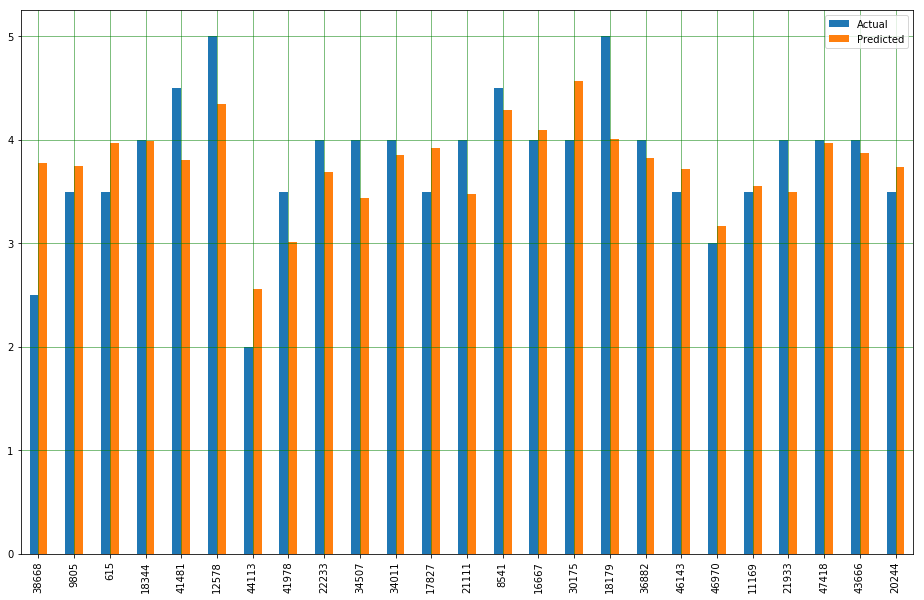

In [48]:
import matplotlib.pyplot as plt
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [49]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.6760389850735586
Mean Squared Error: 0.7858022102180532
Root Mean Squared Error: 0.8864548551494618
